Training on ImageNet-Sim...
Training on GPT-3 Corpus-Sim...
Training on Healthcare Dataset-Sim...


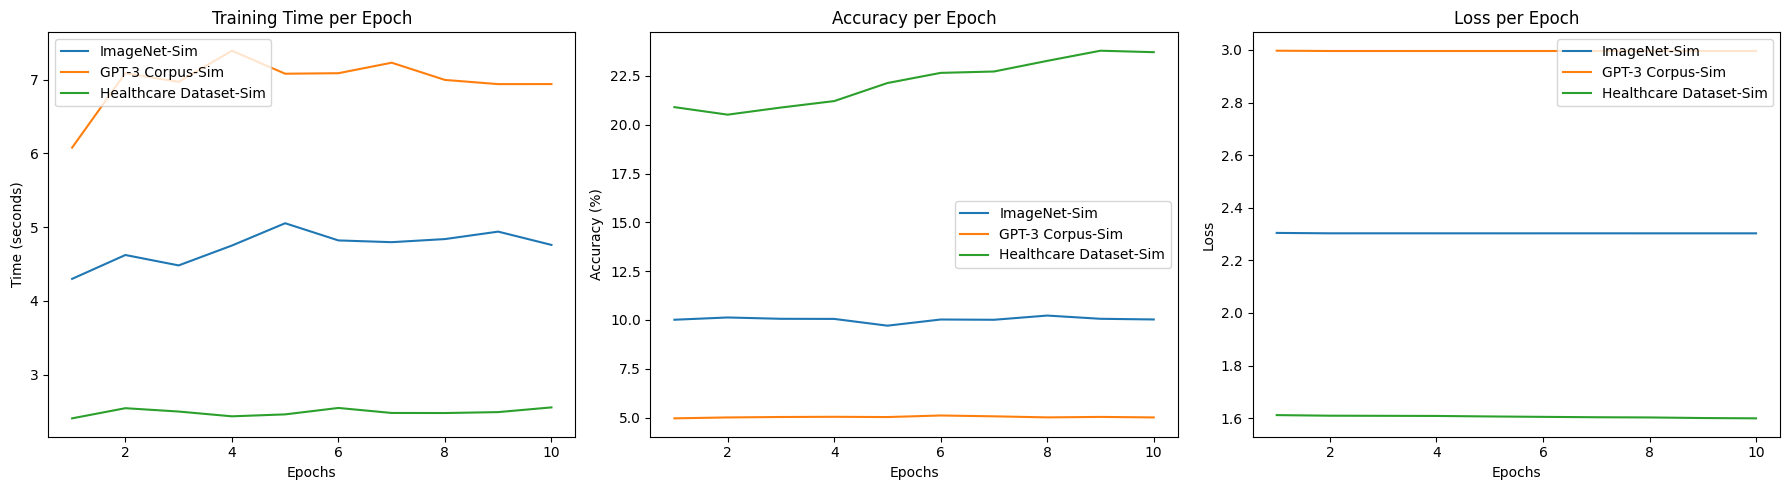

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import time

# Simulated datasets for benchmarking
def create_synthetic_dataset(size, input_dim, output_dim):
    X = torch.rand(size, input_dim)
    y = torch.randint(0, output_dim, (size,))
    return TensorDataset(X, y)

# Define a simple model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.model(x)

# Train the model and record metrics
def train_model(dataset, model, batch_size, epochs, device):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    training_time = []
    accuracy_list = []
    loss_list = []
    
    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        correct, total = 0, 0
        epoch_loss = 0.0
        
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Metrics calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            epoch_loss += loss.item()
        
        end_time = time.time()
        training_time.append(end_time - start_time)
        accuracy_list.append(correct / total * 100)
        loss_list.append(epoch_loss / len(dataloader))
        
    return training_time, accuracy_list, loss_list

# Experiment setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
datasets = {
    "ImageNet-Sim": create_synthetic_dataset(50000, 256, 10),
    "GPT-3 Corpus-Sim": create_synthetic_dataset(100000, 512, 20),
    "Healthcare Dataset-Sim": create_synthetic_dataset(20000, 128, 5),
}
batch_sizes = {"ImageNet-Sim": 64, "GPT-3 Corpus-Sim": 128, "Healthcare Dataset-Sim": 32}
epochs = 10
hidden_dim = 128

# Run experiments and store results
results = {}
for name, dataset in datasets.items():
    input_dim = dataset[0][0].shape[0]
    output_dim = len(torch.unique(torch.tensor([label for _, label in dataset])))
    
    model = SimpleNN(input_dim, hidden_dim, output_dim).to(device)
    batch_size = batch_sizes[name]
    
    print(f"Training on {name}...")
    training_time, accuracy_list, loss_list = train_model(dataset, model, batch_size, epochs, device)
    
    results[name] = {
        "training_time": training_time,
        "accuracy_list": accuracy_list,
        "loss_list": loss_list
    }

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training Time
for name, data in results.items():
    axes[0].plot(range(1, epochs + 1), data["training_time"], label=name)
axes[0].set_title("Training Time per Epoch")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Time (seconds)")
axes[0].legend()

# Accuracy
for name, data in results.items():
    axes[1].plot(range(1, epochs + 1), data["accuracy_list"], label=name)
axes[1].set_title("Accuracy per Epoch")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy (%)")
axes[1].legend()

# Loss
for name, data in results.items():
    axes[2].plot(range(1, epochs + 1), data["loss_list"], label=name)
axes[2].set_title("Loss per Epoch")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Loss")
axes[2].legend()

plt.tight_layout()
plt.show()
